In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import scipy.signal as signal

In [2]:
def extract_weightmap(im):
    "selects the non white part of the image"
    ww = np.zeros(shape=im.shape[:2])
    ww[np.where(im.sum(axis=2) < 4.)] = 1.
    return ww

def invert_weightmap(ww):
    return 1 - ww

# Loading maps

In [3]:
map_oceans = plt.imread("../maps/LOTR_MAPS_oceans.png")
map_rivers = plt.imread("../maps/LOTR_MAPS_rivers.png")
map_hills = plt.imread("../maps/LOTR_MAPS_hills.png")
map_mountains = plt.imread("../maps/LOTR_MAPS_mountains.png")
map_ridges = plt.imread("../maps/LOTR_MAPS_ridges.png")

In [4]:
wmap_oceans = extract_weightmap(map_oceans)
wmap_rivers = extract_weightmap(map_rivers)
wmap_hills = extract_weightmap(map_hills)
wmap_mountains = extract_weightmap(map_mountains)
wmap_ridges = extract_weightmap(map_ridges)

In [5]:
wmap_land = invert_weightmap(wmap_oceans)

# Constructing height map

In [6]:
np.random.seed(5)

In [7]:
sh = wmap_land.shape
num = sh[0] * sh[1]
values = np.random.uniform(size=num)

In [8]:
canvas = np.zeros(shape = wmap_land.shape)
canvas = values.reshape(canvas.shape)

In [97]:
ridge_heights = 4000 # the extra  max heights compared to baseline
mountain_heights = 750
hill_heights = 300
land_heights = 10

In [98]:
raw_canvas = np.zeros(shape = wmap_land.shape)
raw_canvas = np.random.uniform(size=num).reshape(raw_canvas.shape)
canvas = raw_canvas * wmap_land
canvas = ((raw_canvas * wmap_land * land_heights) +
         (raw_canvas * wmap_hills * hill_heights) +
         (raw_canvas * wmap_mountains * mountain_heights) +
         (raw_canvas * wmap_ridges * ridge_heights)) 

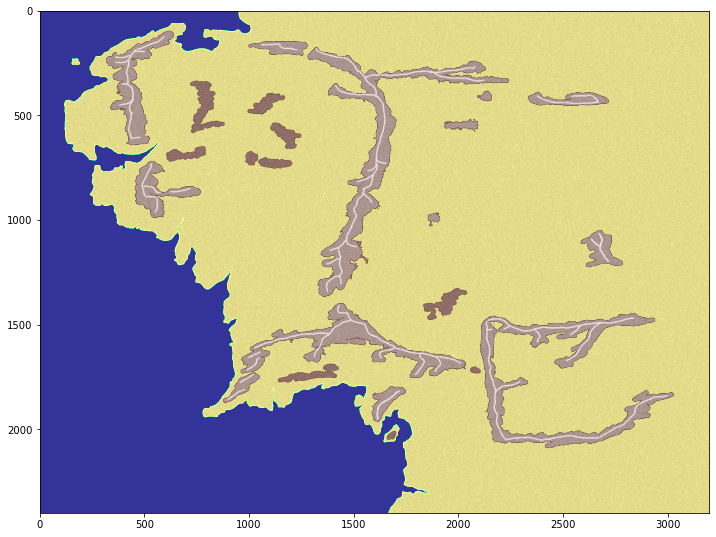

In [99]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.imshow(canvas + 0.001, cmap=plt.cm.terrain, norm=mpl.colors.LogNorm())

# Preparing smoothing and correlation

In [100]:
def distance_kernel(half_extent=50):
    size = half_extent * 2 + 1
    kernel = np.zeros((size, size))
    vals = np.arange(-half_extent,half_extent+1)
    xx, yy = np.meshgrid(vals, vals, indexing='xy')
    # y, x = np.ogrid[-half_extent:half_extent+1, -half_extent:half_extent+1]
    distance = np.sqrt(xx**2 + yy**2)
    return distance
    
def tophat(dists, scale=50.):
    kernel = np.zeros(dists.shape)
    kernel[dists < radius] = 1
    kernel = kernel / kernel.sum()
    return kernel

def gaussian(dists, scale=50.):
    kernel = np.zeros(dists.shape)
    kernel = np.exp(- dists**2. / (2 * scale**2.))
    kernel = kernel / kernel.sum()
    return kernel

def triangle(dists, scale=50):
    """triangle kernel, scale is when it hits zero"""
    kernel = np.zeros(dists.shape)
    kernel = scale - dists
    kernel[kernel < 0] = 0
    kernel = kernel / kernel.sum()
    return kernel
    

    
    


In [101]:
kernels = {
    "gauss": gaussian,
    "tophat": tophat,
    "triangle": triangle,
}

def make_noise_map(scale, shape, which="gauss"):
    num = shape[0] * shape[1]
    noise = np.random.uniform(size=num).reshape(shape)
    dists = distance_kernel(half_extent=scale*3)
    
    
    kern = kernels[which](dists, scale=scale)
    tmp = np.fft.irfft2(np.fft.rfft2(noise) * np.fft.rfft2(kern, noise.shape))
    tmp = tmp - tmp.min()
    tmp = tmp / tmp.max()
    
    return tmp
    

In [102]:
res = make_noise_map(100, raw_canvas.shape)

Text(0.5, 1.0, 'wavelength 100')

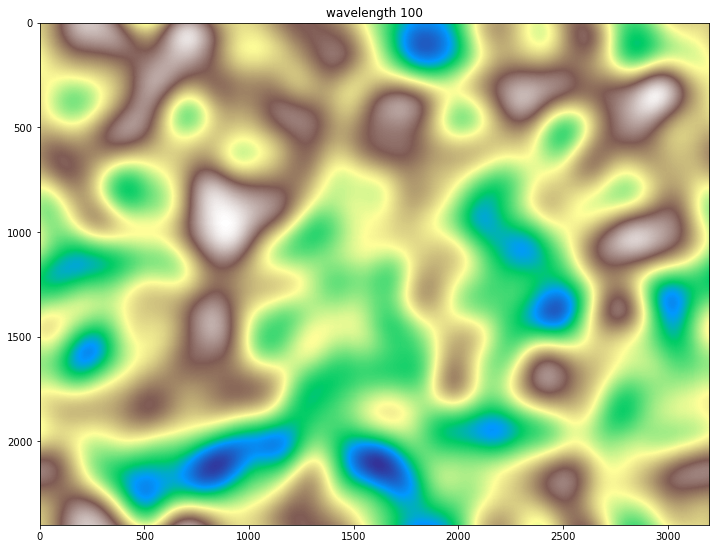

In [103]:

res = make_noise_map(100, raw_canvas.shape)
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.imshow(res, cmap=plt.cm.terrain)
ax.set_title("wavelength 100")

Text(0.5, 1.0, 'wavelength 20')

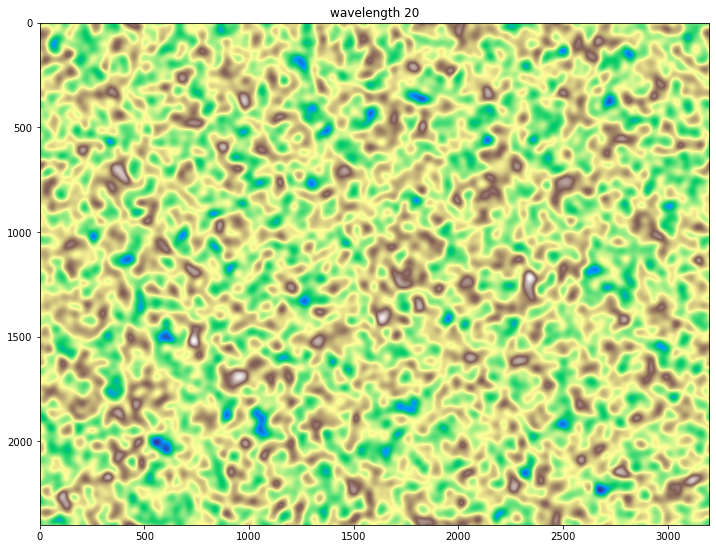

In [104]:

res = make_noise_map(20, raw_canvas.shape)
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.imshow(res, cmap=plt.cm.terrain)
ax.set_title("wavelength 20")

# Creating a layered height map

In [105]:
np.random.seed(5)

In [106]:
ridge_heights = 4000
mountain_heights = 2000
hill_heights = 500
land_heights = 50

land_scale = 200
hill_scale = 20
mountain_scale = 5
ridge_scale = 2

heights = [land_heights, hill_heights, mountain_heights, ridge_heights]
scales = [land_scale, hill_scale, mountain_scale, ridge_scale]
wmaps = [wmap_land, wmap_hills, wmap_mountains, wmap_ridges]

In [107]:
raw_canvas = np.zeros(shape = wmap_land.shape)
canvas = raw_canvas.copy()

for i, (height, scale) in enumerate(zip(heights, scales)):
    print(height, scale)
    canvas += wmaps[i] * make_noise_map(scale, canvas.shape) * height
#canvas += wmap_land * make_noise_map(200, canvas.shape) * land_heights
#canvas += wmap_land * make_noise_map(200, canvas.shape) * land_heights

50 200
500 20
2000 5
4000 2


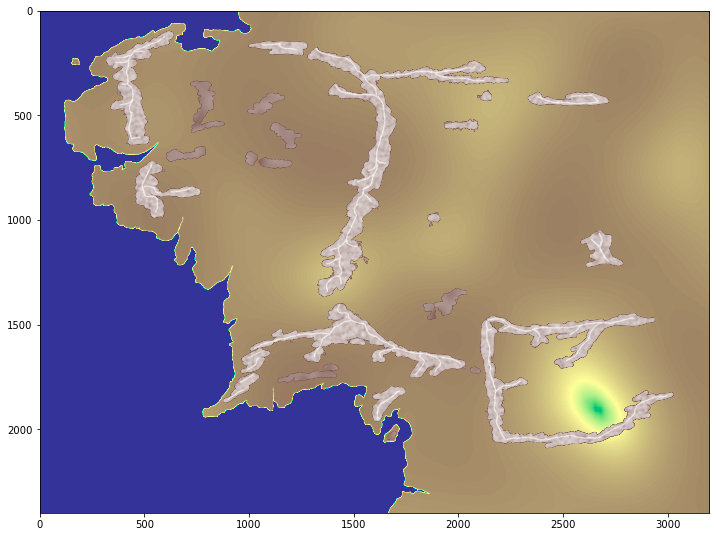

In [108]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.imshow(canvas, cmap=plt.cm.terrain)
ax.imshow(canvas + 0.001, cmap=plt.cm.terrain, norm=mpl.colors.LogNorm())

# Add a smoothing to this map

In [109]:
def convolve_map(canvas, scale, which = "gauss",):
    pad_width = scale*3
    padded = np.pad(canvas, pad_width = scale*3)
    half_extent = scale*2
    dists = distance_kernel(half_extent = half_extent)    
    kern = kernels[which](dists, scale = scale)
    
    # There's some shape difference here, which needs to be manually corrected with the padding
    # just offset the convolved image by the half_extent of the kernel...
    tmp = np.fft.irfft2(np.fft.rfft2(padded) * np.fft.rfft2(kern, padded.shape))
    tmp = tmp[pad_width+half_extent:-pad_width+half_extent, pad_width+half_extent:-pad_width+half_extent]
    return tmp

In [110]:
wavelengths = [5, 10, 20, 30, 60, 90, 180, 340, 460]
#wavelengths = np.round(np.logspace(np.log10(5), 2.7, 16)).astype(int)

maps = []
for ww in wavelengths:
    print(ww)
    tmp = convolve_map(canvas, ww, which = "gauss") * wmap_land
    maps.append(tmp)

5
10
20
30
60
90
180
340
460


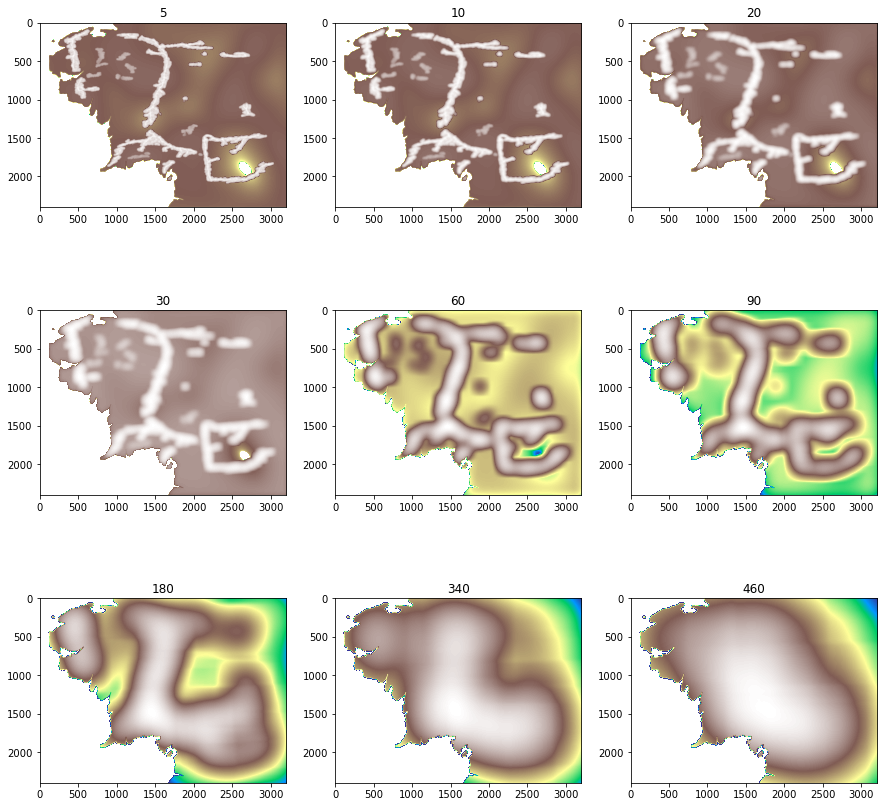

In [111]:
fig, axarr = plt.subplots(3, 3, figsize=(15, 15))
faxarr = axarr.flatten()

for i, ww in enumerate(wavelengths):
    faxarr[i].imshow(maps[i] -1, cmap=plt.cm.terrain, norm=mpl.colors.LogNorm())
    faxarr[i].set_title(ww)

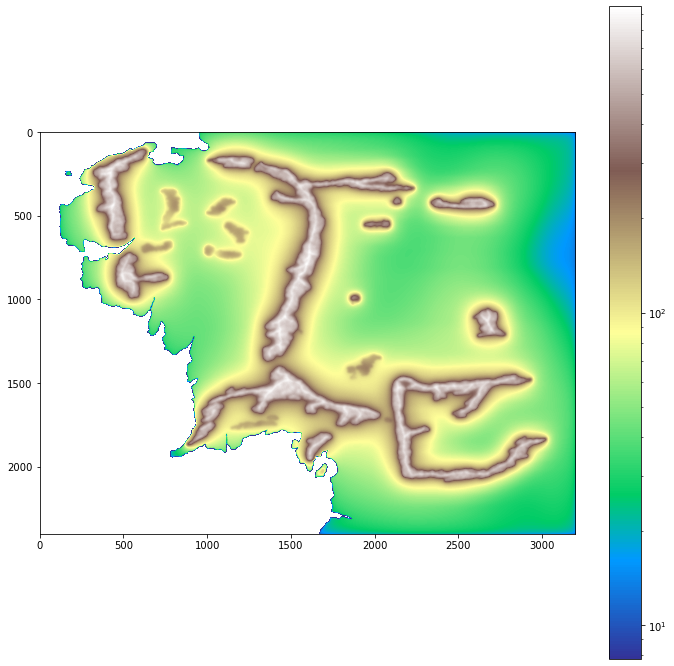

In [112]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
cobj = ax.imshow(np.array(maps).mean(axis=0) -1, cmap=plt.cm.terrain, norm=mpl.colors.LogNorm())
fig.colorbar(cobj)

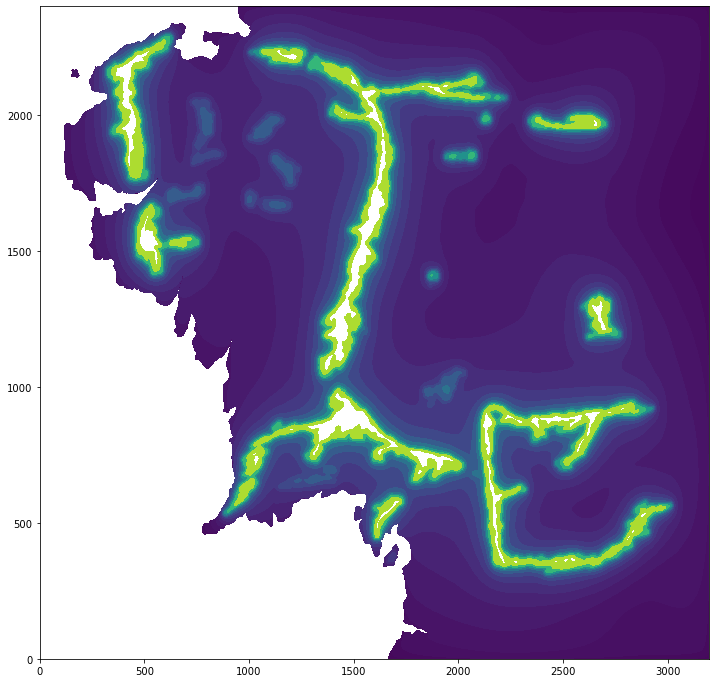

In [89]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
levels = np.logspace(0, 3.5, 30)


weights = np.ones(len(maps))#1 / np.array(wavelengths)**2
mapsum = np.average(maps, weights=weights, axis=0)
mapsum *= canvas.max() / mapsum.max()

xx, yy = np.meshgrid(np.flip(np.arange(canvas.shape[0])), np.arange(canvas.shape[1]), indexing="ij")

plt.contourf(yy.T, xx.T, mapsum.T, levels=levels)

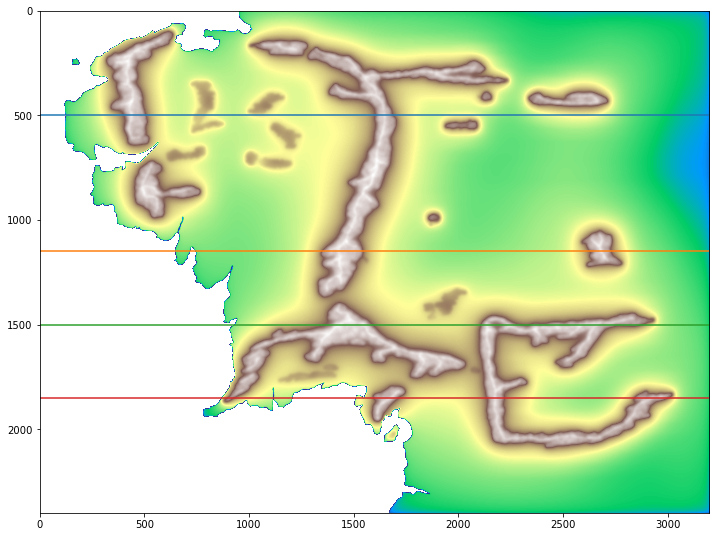

In [90]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.imshow(mapsum -10, cmap=plt.cm.terrain, norm=mpl.colors.LogNorm())

ax.axhline(500, color="C0")
ax.axhline(1150, color="C1")
ax.axhline(1500, color="C2")
ax.axhline(1850, color="C3")

# Smoothing down the coastline heights

In [119]:
ocean_wavelengths = np.array([16, 72, 125])
smooths = []
for ow in ocean_wavelengths:
    tmp = convolve_map(wmap_oceans, ow, which = "triangle") * wmap_land
    smooths.append(tmp)

weights = np.ones(len(smooths))
#weights = (4, 3, 2, 1)
osmooth = np.average(smooths, weights=weights, axis=0)

In [120]:
res = (1 - osmooth) * mapsum

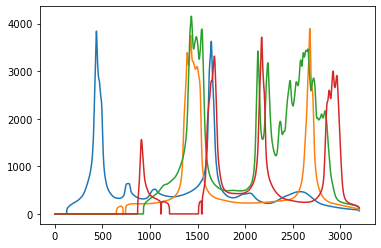

In [121]:
fig = plt.figure()
ax = fig.add_subplot()

ax.plot(res[500, :])
ax.plot(res[1150, :])
ax.plot(res[1500, :])
ax.plot(res[1850, :])

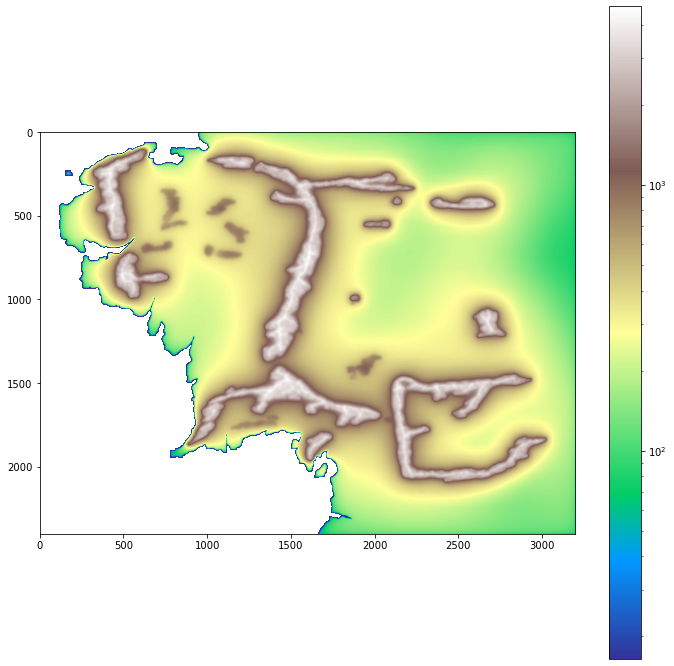

In [122]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
cbar = ax.imshow(res -0.00001, cmap=plt.cm.terrain, norm=mpl.colors.LogNorm())
fig.colorbar(cbar)

In [95]:
np.savez("lotr_map_raw_elevation.npz", res)

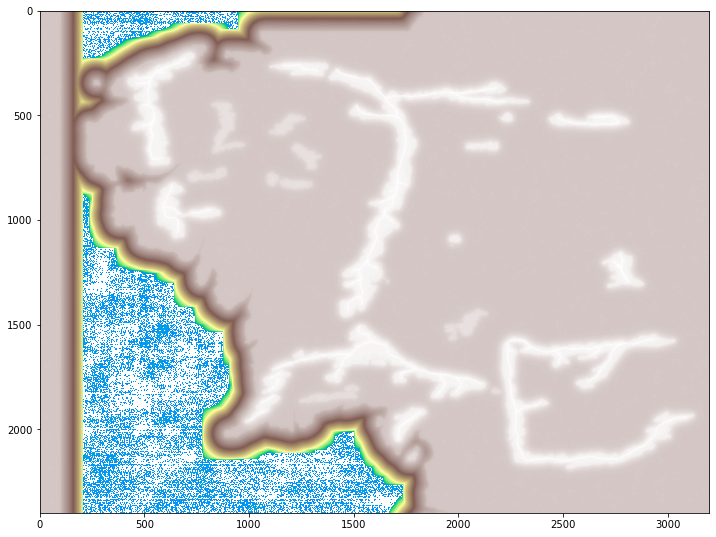

In [78]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.imshow(z, cmap=plt.cm.terrain, norm=mpl.colors.LogNorm())